## Week 7: Reinforcement Learning for seq2seq

This time we'll solve a problem of transribing hebrew words in english, also known as g2p (grapheme2phoneme)

 * word (sequence of letters in source language) -> translation (sequence of letters in target language)

Unlike most deep learning researchers do, we won't only train it to maximize likelihood of correct translation, but also employ reinforcement learning to actually teach it to translate with as few errors as possible.


### About the task

One notable property of Hebrew is that it's consonant language. That is, there are no wovels in the written language. One could represent wovels with diacritics above consonants, but you don't expect people to do that in everyay life.

Therefore, some hebrew characters will correspond to several english letters and others - to none, so we should use encoder-decoder architecture to figure that out.

![img](https://esciencegroup.files.wordpress.com/2016/03/seq2seq.jpg)
_(img: esciencegroup.files.wordpress.com)_

Encoder-decoder architectures are about converting anything to anything, including
 * Machine translation and spoken dialogue systems
 * [Image captioning](http://mscoco.org/dataset/#captions-challenge2015) and [image2latex](https://openai.com/requests-for-research/#im2latex) (convolutional encoder, recurrent decoder)
 * Generating [images by captions](https://arxiv.org/abs/1511.02793) (recurrent encoder, convolutional decoder)
 * Grapheme2phoneme - convert words to transcripts
  
We chose simplified __Hebrew->English__ machine translation for words and short phrases (character-level), as it is relatively quick to train even without a gpu cluster.

In [1]:
EASY_MODE = True        #If True, only translates phrases shorter than 20 characters (way easier).
                        #Useful for initial coding.
                        #If false, works with all phrases (please switch to this mode for homework assignment)

MODE = "he-to-en"                                # way we translate. Either "he-to-en" or "en-to-he"
MAX_OUTPUT_LENGTH = 50 if not EASY_MODE else 20  # maximal length of _generated_ output, does not affect training
REPORT_FREQ       = 100                          # how often to evaluate validation score


### Step 1: preprocessing

We shall store dataset as a dictionary
`{ word1:[translation1,translation2,...], word2:[...],...}`.

This is mostly due to the fact that many words have several correct translations.

We have implemented this thing for you so that you can focus on more interesting parts.


__Attention python2 users!__ You may want to cast everything to unicode later during homework phase, just make sure you do it _everywhere_.

In [2]:
import numpy as np
from collections import defaultdict
word_to_translation = defaultdict(list) #our dictionary

bos = '_'
eos = ';'

with open("main_dataset.txt",encoding='utf8') as fin:
    for line in fin:
        
        en,he = line[:-1].lower().replace(bos,' ').replace(eos,' ').split('\t')
        word,trans = (he,en) if MODE=='he-to-en' else (en,he)
        
        if len(word) < 3: continue
        if EASY_MODE:
            if max(len(word),len(trans))>20:
                continue
        
        word_to_translation[word].append(trans)
    
print ("size = ",len(word_to_translation))

size =  130113


In [3]:
#get all unique lines in source language
all_words = np.array(list(word_to_translation.keys()))
# get all unique lines in translation language
all_translations = np.array([ts for all_ts in word_to_translation.values() for ts in all_ts])


### split the dataset

We hold out 10% of all words to be used for validation.


In [4]:
from sklearn.model_selection import train_test_split
train_words,test_words = train_test_split(all_words,test_size=0.1,random_state=42)

### Building vocabularies

We now need to build vocabularies that map strings to token ids and vice versa. We're gonna need these fellas when we feed training data into model or convert output matrices into english words.

In [5]:
from voc import Vocab
inp_voc = Vocab.from_lines(''.join(all_words), bos=bos, eos=eos, sep='')
out_voc = Vocab.from_lines(''.join(all_translations), bos=bos, eos=eos, sep='')

In [6]:
# Here's how you cast lines into ids and backwards.
batch_lines = all_words[:5]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['אנרכיזם' 'אוטיזם קלאסי' 'אלבדו' 'אלבמה' 'אכילס']

words to ids (0 = bos, 1 = eos):
[[  0 165  33  98  91 179  48 169   1   1   1   1   1   1]
 [  0 165  43  57 179  48 169 126  85  52 165  11 179   1]
 [  0 165  52  34  47  43   1   1   1   1   1   1   1   1]
 [  0 165  52  34  96  44   1   1   1   1   1   1   1   1]
 [  0 165  91 179  52  11   1   1   1   1   1   1   1   1]]

back to words
['אנרכיזם', 'אוטיזם קלאסי', 'אלבדו', 'אלבמה', 'אכילס']


Draw word/translation length distributions to estimate the scope of the task.

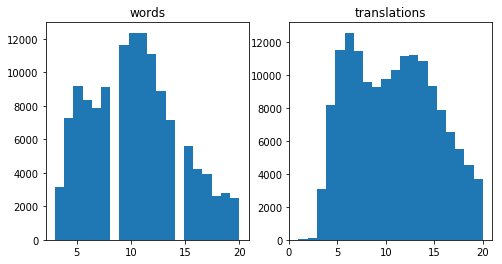

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.title("words")
plt.hist(list(map(len,all_words)),bins=20);

plt.subplot(1,2,2)
plt.title('translations')
plt.hist(list(map(len,all_translations)),bins=20);


### Step 3: deploy encoder-decoder (1 point)

__assignment starts here__

Our architecture consists of two main blocks:
* Encoder reads words character by character and outputs code vector (usually a function of last RNN state)
* Decoder takes that code vector and produces translations character by character

Than it gets fed into a model that follows this simple interface:
* __`model.symbolic_translate(inp, **flags) -> out, logp`__ - takes symbolic int32 matrix of hebrew words, produces output tokens sampled from the model and output log-probabilities for all possible tokens at each tick.
* __`model.symbolic_score(inp, out, **flags) -> logp`__ - takes symbolic int32 matrices of hebrew words and their english translations. Computes the log-probabilities of all possible english characters given english prefices and hebrew word.

That's all! It's as hard as it gets. With those two methods alone you can implement all kinds of prediction and training.

In [8]:
# set flags here if necessary
import theano
theano.config.floatX = 'float32'
import theano.tensor as T
import lasagne

In [10]:
!pip install agentnet

  Could not find a version that satisfies the requirement agentnet (from versions: )
No matching distribution found for agentnet


In [9]:
from basic_model_theano import BasicTranslationModel
model = BasicTranslationModel(inp_voc,out_voc,
                              emb_size=64, hid_size=128)

ModuleNotFoundError: No module named 'agentnet'

In [ ]:
# Play around with symbolic_translate and symbolic_score
inp = T.constant(np.random.randint(0,10,[3,5],dtype='int32'))
out = T.constant(np.random.randint(0,10,[3,5],dtype='int32'))

# translate inp (with untrained model)
sampled_out, logp = out,model.symbolic_translate(inp, greedy=False)
dummy_translate = theano.function([],sampled_out, updates=model.auto_updates)

print("\nSymbolic_translate output:\n",out,logp)
print("\nSample translations:\n", dummy_translate())

In [ ]:
# score logp(out | inp) with untrained input
logp = model.symbolic_score(inp,out)
dummy_score = theano.function([],logp)

print("\nSymbolic_score output:\n",logp)
print("\nLog-probabilities (clipped):\n", dummy_score()[:,:2,:5])

In [ ]:
# Prepare any operations you want here

inp = T.imatrix("input tokens [batch,time]")
trans, _ = <build symbolic translations with greedy=True>
translate_fun = theano.function([inp], trans,updates=model.auto_updates)

def translate(lines):
    """
    You are given a list of input lines. 
    Make your neural network translate them.
    :return: a list of output lines
    """
    # Convert lines to a matrix of indices
    lines_ix = <YOUR CODE>
    
    # Compute translations in form of indices (call your function)
    trans_ix = <YOUR CODE>
    
    # Convert translations back into strings
    return out_voc.to_lines(trans_ix)
    

In [ ]:
print("Sample inputs:",all_words[:3])
print("Dummy translations:",translate(all_words[:3]))

assert trans.ndim==2 and trans.dtype.startswith('int'), "trans must be a tensor of integers (token ids)"
assert translate(all_words[:3]) == translate(all_words[:3]), "make sure translation is deterministic (use greedy=True and disable any noise layers)"
assert type(translate(all_words[:3])) is list and (type(translate(all_words[:1])[0]) is str or type(translate(all_words[:1])[0]) is unicode), "translate(lines) must return a sequence of strings!"
print("Tests passed!")

### Scoring function

LogLikelihood is a poor estimator of model performance.
* If we predict zero probability once, it shouldn't ruin entire model.
* It is enough to learn just one translation if there are several correct ones.
* What matters is how many mistakes model's gonna make when it translates!

Therefore, we will use minimal Levenshtein distance. It measures how many characters do we need to add/remove/replace from model translation to make it perfect. Alternatively, one could use character-level BLEU/RougeL or other similar metrics.

The catch here is that Levenshtein distance is not differentiable: it isn't even continuous. We can't train our neural network to maximize it by gradient descent.

In [ ]:
import editdistance # !pip install editdistance

def get_distance(word,trans):
    """
    A function that takes word and predicted translation
    and evaluates (Levenshtein's) edit distance to closest correct translation
    """
    references = word_to_translation[word]
    assert len(references)!=0,"wrong/unknown word"
    return min(editdistance.eval(trans,ref) for ref in references)

def score(words, bsize=100):
    """a function that computes levenshtein distance for bsize random samples"""
    assert isinstance(words,np.ndarray)
    
    batch_words = np.random.choice(words,size=bsize,replace=False)
    batch_trans = translate(batch_words)
    
    distances = list(map(get_distance,batch_words,batch_trans))
    
    return np.array(distances,dtype='float32')

In [ ]:
#should be around 5-50 and decrease rapidly after training :)
[score(test_words,10).mean() for _ in range(5)]

## Step 2: Supervised pre-training

Here we define a function that trains our model through maximizing log-likelihood a.k.a. minimizing crossentropy.

In [ ]:
from agentnet.learning.generic import get_values_for_actions, get_mask_by_eos

class llh_trainer:

    # variable for correct answers
    input_sequence = T.imatrix("input sequence [batch,time]")
    reference_answers = T.imatrix("reference translations [batch, time]")
    
    # Compute log-probabilities of all possible tokens at each step. Use model interface.
    logprobs_seq = <YOUR CODE>
    
    # compute mean crossentropy
    crossentropy = - get_values_for_actions(logprobs_seq,reference_answers)
    
    mask = get_mask_by_eos(T.eq(reference_answers, out_voc.eos_ix))
    
    loss = T.sum(crossentropy * mask)/T.sum(mask)

    # Build weight updates. Use model.weights to get all trainable params.
    updates = <YOUR CODE>
    
    train_step = theano.function([input_sequence,reference_answers], loss, updates=updates)

Actually run training on minibatches

In [ ]:
import random
def sample_batch(words, word_to_translation, batch_size):
    """
    sample random batch of words and random correct translation for each word
    example usage:
    batch_x,batch_y = sample_batch(train_words, word_to_translations,10)
    """
    #choose words
    batch_words = np.random.choice(words,size=batch_size)
    
    #choose translations
    batch_trans_candidates = list(map(word_to_translation.get,batch_words))
    batch_trans = list(map(random.choice,batch_trans_candidates))
    
    return inp_voc.to_matrix(batch_words), out_voc.to_matrix(batch_trans)

In [ ]:
bx,by = sample_batch(train_words, word_to_translation, batch_size=3)
print("Source:")
print(bx)
print("Target:")
print(by)

In [ ]:
from IPython.display import clear_output
from tqdm import tqdm,trange #or use tqdm_notebook,tnrange

loss_history=[]
editdist_history = []

for i in trange(25000):
    loss = llh_trainer.train_step(*sample_batch(train_words,word_to_translation,32))
    loss_history.append(loss)
    
    if (i+1)%REPORT_FREQ==0:
        clear_output(True)
        current_scores = score(test_words)
        editdist_history.append(current_scores.mean())
        plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.title('train loss / traning time')
        plt.plot(loss_history)
        plt.grid()
        plt.subplot(132)
        plt.title('val score distribution')
        plt.hist(current_scores, bins = 20)
        plt.subplot(133)
        plt.title('val score / traning time')
        plt.plot(editdist_history)
        plt.grid()
        plt.show()
        print("llh=%.3f, mean score=%.3f"%(np.mean(loss_history[-10:]),np.mean(editdist_history[-10:])))


In [ ]:
for word in train_words[:10]:
    print("%s -> %s"%(word,translate([word])[0]))

In [ ]:
test_scores = []
for start_i in trange(0,len(test_words),32):
    batch_words = test_words[start_i:start_i+32]
    batch_trans = translate(batch_words)
    distances = list(map(get_distance,batch_words,batch_trans))
    test_scores.extend(distances)
    
print("Supervised test score:",np.mean(test_scores))

## Preparing for reinforcement learning (2 points)

First we need to define loss function as a custom theano operation.

The simple way to do so is
```
@theano.compile.as_op(input_types,output_type(s),infer_shape)
def my_super_function(inputs):
    return outputs
```




__Your task__ is to implement `_compute_levenshtein` function that takes matrices of words and translations, along with input masks, then converts those to actual words and phonemes and computes min-levenshtein via __get_distance__ function above.


In [ ]:
@theano.compile.as_op([T.imatrix]*2,[T.fvector],lambda _,shapes: [shapes[0][:1]])
def _compute_levenshtein(words_ix,trans_ix):
    """
    A custom theano operation that computes levenshtein loss for predicted trans.
    
    Params:
    - words_ix - a matrix of letter indices, shape=[batch_size,word_length]
    - words_mask - a matrix of zeros/ones, 
       1 means "word is still not finished"
       0 means "word has already finished and this is padding"
    
    - trans_mask - a matrix of output letter indices, shape=[batch_size,translation_length]
    - trans_mask - a matrix of zeros/ones, similar to words_mask but for trans_ix
    
    
    Please implement the function and make sure it passes tests from the next cell.
    
    """
    
    #convert words to strings
    words = <restore words (a list of strings) from words_ix>

    assert type(words) is list and type(words[0]) is str and len(words)==len(words_ix)
    
    #convert translations to lists
    translations = <restore trans (a list of lists of phonemes) from trans_ix

    assert type(translations) is list and type(translations[0]) is str and len(translations)==len(trans_ix)

    #computes levenstein distances. can be arbitrary python code.
    distances = <apply get_distance to each pair of [words,translations]>
    
    assert type(distances) in (list,tuple,np.ndarray) and len(distances) == len(words_ix)
    
    distances = np.array(list(distances),dtype='float32')
    return distances

#forbid gradient
from theano.gradient import disconnected_grad
def compute_levenshtein(*args):
    return disconnected_grad(_compute_levenshtein(*[arg.astype('int32') for arg in args]))

Simple test suite to make sure your implementation is correct. Hint: if you run into any bugs, feel free to use print from inside _compute_levenshtein.

In [ ]:
#test suite
#sample random batch of (words, correct trans, wrong trans)
batch_words = np.random.choice(train_words, size=100 )
batch_trans = list(map(random.choice,map(word_to_translation.get,batch_words )))
batch_trans_wrong = np.random.choice(all_translations,size=100)

batch_words_ix = T.constant(inp_voc.to_matrix(batch_words))
batch_trans_ix = T.constant(out_voc.to_matrix(batch_trans))
batch_trans_wrong_ix = T.constant(out_voc.to_matrix(batch_trans_wrong))

In [ ]:
#assert compute_levenshtein is zero for ideal translations
correct_answers_score = compute_levenshtein(batch_words_ix,batch_trans_ix).eval()

assert np.all(correct_answers_score==0),"a perfect translation got nonzero levenshtein score!"

print("Everything seems alright!")

In [ ]:
#assert compute_levenshtein matches actual scoring function
wrong_answers_score = compute_levenshtein(batch_words_ix,batch_trans_wrong_ix).eval()

true_wrong_answers_score = np.array(list(map(get_distance,batch_words,batch_trans_wrong)))

assert np.all(wrong_answers_score==true_wrong_answers_score),"for some word symbolic levenshtein is different from actual levenshtein distance"

print("Everything seems alright!")

Once you got it working...


* You may now want to __remove/comment asserts__ from function code for a slight speed-up.

* There's a more detailed tutorial on custom theano ops here: [docs](http://deeplearning.net/software/theano/extending/extending_theano.html), [example](https://gist.github.com/justheuristic/9f4ffef6162a8089c3260fc3bbacbf46).

## Self-critical policy gradient (2 points)

In this section you'll implement algorithm called self-critical sequence training (here's an [article](https://arxiv.org/abs/1612.00563)).

The algorithm is a vanilla policy gradient with a special baseline. 

$$ \nabla J = E_{x \sim p(s)} E_{y \sim \pi(y|x)} \nabla log \pi(y|x) \cdot (R(x,y) - b(x)) $$

Here reward R(x,y) is a __negative levenshtein distance__ (since we minimize it). The baseline __b(x)__ represents how well model fares on word __x__.

In practice, this means that we compute baseline as a score of greedy translation, $b(x) = R(x,y_{greedy}(x)) $.

Luckily, we already obtained the required outputs: `model.greedy_translations, model.greedy_mask` and we only need to compute levenshtein using `compute_levenshtein` function.


In [ ]:

class trainer:    
    
    input_sequence = T.imatrix("input tokens [batch,time]")

    # use model to __sample__ symbolic translations given input_sequence
    sample_translations, sample_logp = <your code here>
    auto_updates = model.auto_updates
    # use model to __greedy__ symbolic translations given input_sequence
    greedy_translations, greedy_logp = <your code here>
    greedy_auto_updates = model.auto_updates
    
    # Note: you can use model.symbolic_translate(...,unroll_scan=True,max_len=MAX_OUTPUT_LENGTH)
    # to run much faster at a cost of longer compilation
    
    
    rewards = - compute_levenshtein(input_sequence, sample_translations)
    
    baseline = <compute __negative__ levenshtein for greedy mode>
    
    # compute advantage using rewards and baseline
    advantage = <your code - compute advantage>
    
    # compute log_pi(a_t|s_t), shape = [batch, seq_length]
    logprobs_phoneme = get_values_for_actions(sample_logp, sample_translations)
    
    # policy gradient
    J = logprobs_phoneme*advantage[:,None]
    
    mask = get_mask_by_eos(T.eq(sample_translations,out_voc.eos_ix))
    loss = - T.sum(J*mask) / T.sum(mask)
    
    # regularize with negative entropy. Don't forget the sign!
    # note: for entropy you need probabilities for all tokens (sample_logp), not just phoneme_logprobs
    entropy = <compute entropy matrix of shape [batch,seq_length], H=-sum(p*log_p), don't forget the sign!>
    
    assert entropy.ndim == 2, "please make sure elementwise entropy is of shape [batch,time]"

    loss -= 0.01*T.sum(entropy*mask) / T.sum(mask)
    
    # compute weight updates, clip by norm
    grads = T.grad(loss,model.weights)
    grads = lasagne.updates.total_norm_constraint(grads,50)

    updates = lasagne.updates.adam(grads, model.weights,learning_rate=1e-5) 

    train_step = theano.function([input_sequence],loss,
                                 updates = auto_updates+greedy_auto_updates+updates)
    
    
    
    

# Policy gradient training


In [ ]:
for i in trange(100000):
    loss_history.append(
        trainer.train_step(sample_batch(train_words,word_to_translation,32)[0])
        )
    
    if (i+1)%REPORT_FREQ==0:
        clear_output(True)
        current_scores = score(test_words)
        editdist_history.append(current_scores.mean())
        plt.figure(figsize=(8,4))
        plt.subplot(121)
        plt.title('val score distribution')
        plt.hist(current_scores, bins = 20)
        plt.subplot(122)
        plt.title('val score / traning time')
        plt.plot(editdist_history)
        plt.grid()
        plt.show()
        print("J=%.3f, mean score=%.3f"%(np.mean(loss_history[-10:]),np.mean(editdist_history[-10:])))

In [ ]:
model.translate("EXAMPLE;")

### Results

In [ ]:
for word in train_words[:10]:
    print("%s -> %s"%(word,translate([word])[0]))

In [ ]:
test_scores = []
for start_i in trange(0,len(test_words),32):
    batch_words = test_words[start_i:start_i+32]
    batch_trans = translate(batch_words)
    distances = list(map(get_distance,batch_words,batch_trans))
    test_scores.extend(distances)
print("Supervised test score:",np.mean(test_scores))

# ^^ If you get Out Of Memory, please replace this with batched computation

## Step 6: Make it actually work (5++ pts)

In this section we want you to finally __restart with EASY_MODE=False__ and experiment to find a good model/curriculum for that task.

We recommend the following architecture

```
encoder---decoder

           P(y|h)
             ^
 LSTM  ->   LSTM
  ^          ^
 LSTM  ->   LSTM
  ^          ^
input       y_prev
```

with __both__ LSTMs having equal or more units than the default gru.


It's okay to modify the code above without copy-pasting it.

__Some tips:__
* You will likely need to adjust pre-training time for such a network.
* Supervised pre-training may benefit from clipping gradients somehow.
* SCST may indulge a higher learning rate in some cases and changing entropy regularizer over time.
* There's more than one way of sending information from encoder to decoder, especially if there's more than one layer:
  * __Vanilla:__ layer_i of encoder last state goes to layer_i of decoder initial state
  * __Intermediate layers:__ add dense (and possibly concat) layers between encoder last and decoder first.
  * __Every tick:__ feed encoder last state _on every iteration_ of decoder.


* It's often useful to save pre-trained model parameters to not re-train it every time you want new policy gradient parameters. 
* When leaving training for nighttime, try setting REPORT_FREQ to a larger value (e.g. 500) not to waste time on it.


* (advanced deep learning) It may be a good idea to first train on small phrases and then adapt to larger ones (a.k.a. training curriculum).
* (advanced nlp) You may want to switch from raw utf8 to something like unicode or even syllables to make task easier.
* (advanced nlp) Since hebrew words are written __with vowels omitted__, you may want to use a small Hebrew vowel markup dataset at `he-pron-wiktionary.txt`.

__Formal criteria__:

To get 5 points we want you to build an architecture that:
* _doesn't consist of single GRU_
* _works better_ than single GRU baseline. 
* We also want you to provide either learning curve or trained model, preferably both
* ... and write a brief report or experiment log describing what you did and how it fared.

### Bonus hints: [here](https://github.com/yandexdataschool/Practical_RL/blob/master/week8/8.2_bonus.ipynb)

In [ ]:
assert not EASY_MODE, "make sure you set EASY_MODE = False at the top of the notebook."

`[your report/log here or anywhere you please]`

__Contributions:__ This notebook is brought to you by
* Yandex [MT team](https://tech.yandex.com/translate/)
* Denis Mazur ([DeniskaMazur](https://github.com/DeniskaMazur)), Oleg Vasilev ([Omrigan](https://github.com/Omrigan/)), Dmitry Emelyanenko ([TixFeniks](https://github.com/tixfeniks)) and Fedor Ratnikov ([justheuristic](https://github.com/justheuristic/))
* Dataset is parsed from [Wiktionary](https://en.wiktionary.org), which is under CC-BY-SA and GFDL licenses.
